In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error

from data.city.load_cities import CITY
from data.prediction.methods.mean_predictor import PredictByMean
from data.prediction.methods.XGBoost import PredictByXGBoost

In [3]:
TRAIN_SIZE = 0.7
method = PredictByMean(city=CITY,prediction_length=24*7,train_size=TRAIN_SIZE)
method.train()

station = method.df_dataset.columns[0]
r = method.df_dataset[station].iloc[:168]
method.predict(station, r)

# On calcule la MSE totale pour toutes les stations

mse_values = []
for station in method.df_dataset.columns:
    r = method.df_dataset[station].iloc[:168]
    prediction = method.predict(station, r)
    mse = mean_squared_error(r, prediction)
    mse_values.append(mse)
    
print(f"MSE: {np.mean(mse_values)}")

MSE: 0.062065967586756206


In [4]:
model = PredictByMean(city=CITY,prediction_length=24*7,train_size=TRAIN_SIZE)
model.train()

start_week = 168 * 3
station = 1

df_predict: pd.DataFrame = model.predict(data=CITY.df_hours.columns[station]).reset_index(drop=True)
df_predict[CITY.df_hours.columns[station] + '-obs'] = CITY.df_hours[CITY.df_hours.columns[station]].iloc[start_week:start_week + len(df_predict)].reset_index(drop=True)
df_predict.index = CITY.df_hours['date'].iloc[start_week:start_week + len(df_predict)]

print('MSE:', mean_squared_error(df_predict[df_predict.columns[1]], df_predict[df_predict.columns[0]]))

fig = px.line(
    data_frame=df_predict
)

fig.update_layout(hovermode='x')

fig.show()

TypeError: PredictByMean.predict() missing 1 required positional argument: 'selected_stations'

In [9]:
TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24*7  # Prédiction sur une semaine
method = PredictByXGBoost(city=CITY, prediction_length=PREDICTION_LENGTH, train_size=TRAIN_SIZE)
method.train()

C:\Users\theo3\AppData\Local\Temp\ipykernel_20776\2744920715.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start, end=end, freq='H')


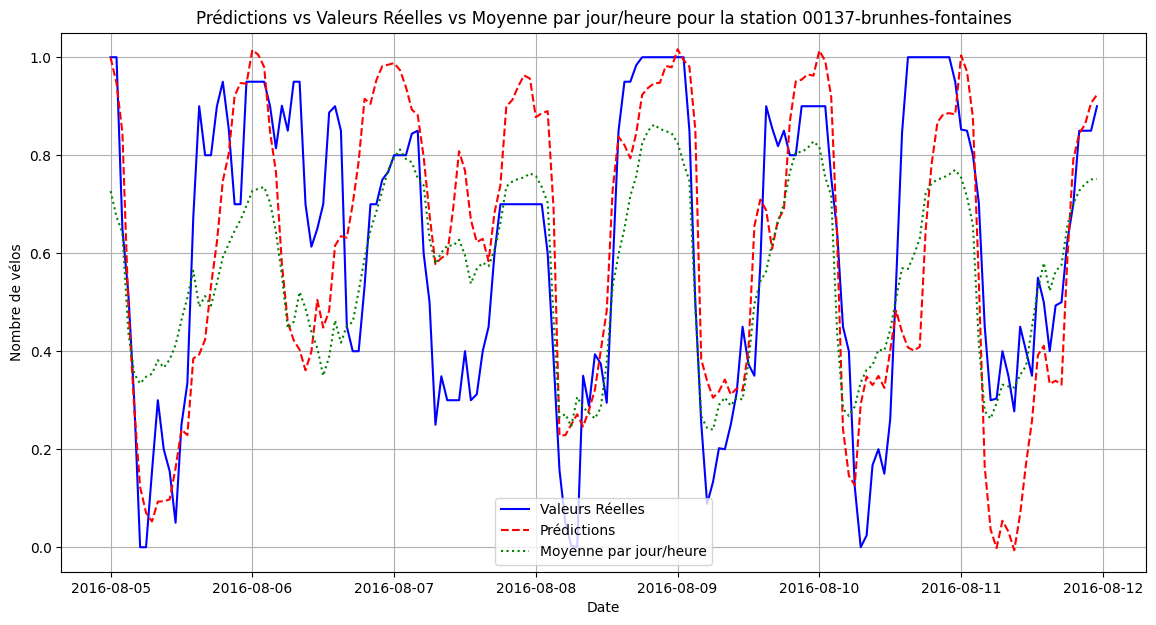

MSE pour les prédictions sur la station 00137-brunhes-fontaines: 0.050567530250066224


In [10]:
station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]  

start_prediction = last_train_date + pd.DateOffset(hours=1)  
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)  
real_data = method.df_dataset.loc[start_prediction:end_prediction, station]

predictions = method.predict(station)

df_mean = method.df_dataset.copy()
df_mean = df_mean.loc[:last_train_date]
df_mean['hour'] = df_mean.index.hour
df_mean['day_of_week'] = df_mean.index.dayofweek
hourly_weekday_mean = df_mean.groupby(['day_of_week', 'hour'])[station].mean().unstack()

def get_hourly_weekday_means(start, end):
    index = pd.date_range(start=start, end=end, freq='H')
    mean_values = [hourly_weekday_mean.loc[date.dayofweek, date.hour] for date in index]
    return pd.Series(data=mean_values, index=index)

predicted_means = get_hourly_weekday_means(start_prediction, end_prediction)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red', linestyle='--')
plt.plot(predicted_means.index, predicted_means.values, label='Moyenne par jour/heure', color='green', linestyle=':')
plt.title(f'Prédictions vs Valeurs Réelles vs Moyenne par jour/heure pour la station {station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.show()


# Calculer la Mean Squared Error
mse = mean_squared_error(real_data.values, predictions.values)
print(f'MSE pour les prédictions sur la station {station}: {mse}')


In [ ]:
# On calcule la MSE totale pour toutes les stations
mse_values = []

for station in method.df_dataset.columns:
    real_data = method.df_dataset.loc[start_prediction:end_prediction, station]
    predictions = method.predict(station)

    mse = mean_squared_error(real_data.values, predictions.values)
    mse_values.append(mse)
    
total_mse = np.mean(mse_values)
print(f'MSE totale pour les prédictions sur toutes les stations: {total_mse}')

MSE totale pour les prédictions sur toutes les stations: 0.08207239141344218


In [ ]:
DATE_RANGE = ('04-01-2016', '10-31-2016')

df = pd.read_csv(
    f'./data/city/Toulouse/X_hour_toulouse.csv',
    index_col=0
)
df['date'] = pd.date_range(*DATE_RANGE, freq='1h')[:len(df)]
df.set_index('date', inplace=True)

In [ ]:
a = pd.Series([False, True, True, False, True], index=[0, 1, 2, 9, 10])
a[0]

False

In [ ]:
def get_interpolated_indices(serie: pd.Series, tolerance: float=1e-3, output_type: str='mask'):

    mask, current_mask = [], []
    for index in range(len(serie)):
        # Si < 2 éléments d'affilé de suite
        if len(current_mask) < 2:
            current_mask.append(serie.index.values[index])
            continue
        
        # On check si la différence est la même entre trois éléments d'affilé de suite
        if np.abs((serie.values[index - 2] - serie.values[index - 1]) - (serie.values[index - 1] - serie.values[index])) < tolerance:
            current_mask.append(serie.index.values[index])
            continue
        
        # Si la différence est constante et la longueur de l'interpolation < 24 heures
        if len(current_mask) < 24 and np.abs(serie.values[index - 2] - serie.values[index - 1]) < tolerance:
            current_mask = []

        if len(current_mask) > 2:
            mask.append(current_mask[1:-1])
        current_mask = [serie.index.values[index - 1], serie.index.values[index]]

    if output_type == 'mask':
        return serie[[index_mask for row in mask for index_mask in row]].index

    if output_type == 'list':
        return mask
    
    raise ValueError('The "output_type" value must be one of the following : "mask", "list".')

In [ ]:
index_column = 0
tmp = df.loc[:].iloc[:, index_column].copy()
# tmp = pd.Series([-2, 1, 2, 3, 84, 56, 98, 5, 4, 3, 2, 92])

index = get_interpolated_indices(tmp, output_type='list')
print(len(index))
index = [u for v in index for u in v]
tmp.loc[index] = np.nan

a = tmp.to_frame()
a['origine'] = df.iloc[:, index_column].copy()
fig = px.line(a).show()

51


## Mathilde (si c'est faux, pardon)

Forêt aléatoire

In [22]:
from sklearn.ensemble import RandomForestRegressor

station = method.df_dataset.columns[73]  # Changer la station ici

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24*7  # Prédiction sur une semaine

model = RandomForestRegressor(n_estimators=100, random_state=0)
X_train = method.train_dataset.drop(station, axis=1)
y_train = method.train_dataset[station]
X_test = method.df_dataset.drop(station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[station].loc[start_prediction:end_prediction]
common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')
r_squared = model.score(X_test, y_test)
print(f'R² pour les prédictions sur la station {station}: {r_squared}')


MSE pour les prédictions sur la station 00120-ponts-jumeaux: 0.052498036143551134
R² pour les prédictions sur la station 00120-ponts-jumeaux: 0.5248478335259223


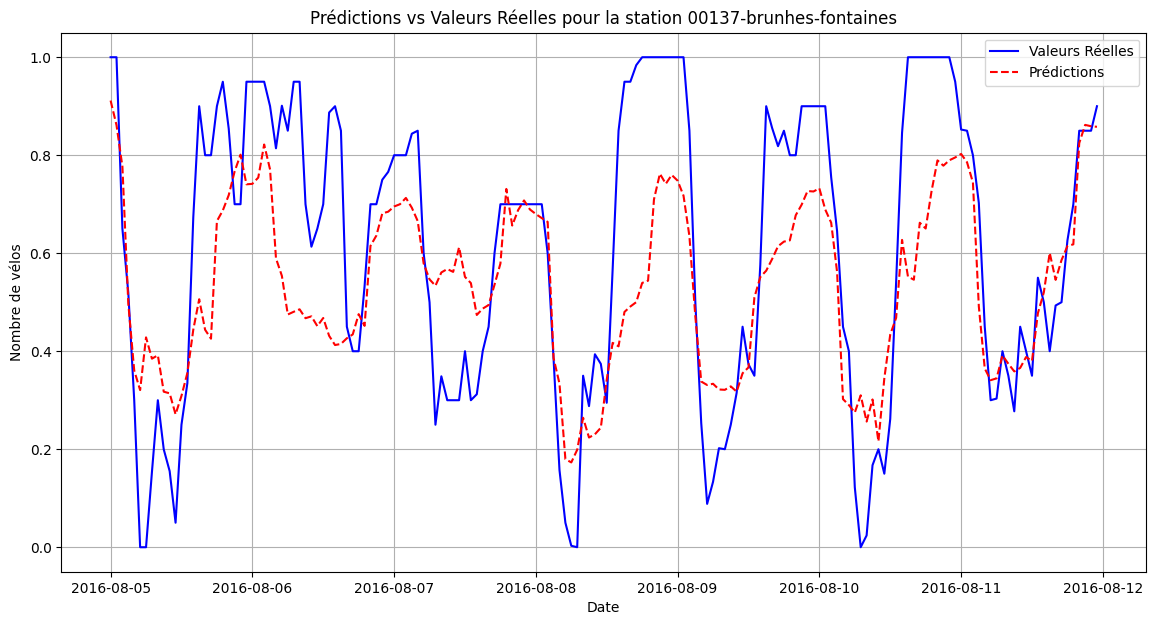

In [ ]:
from sklearn.ensemble import RandomForestRegressor

new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]
model = RandomForestRegressor(n_estimators=100, random_state=0)
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()


Réseau de neurones

In [46]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24*7  # Prédiction sur une semaine

station = method.df_dataset.columns[0]  # Changer la station ici

model = MLPRegressor(hidden_layer_sizes=(180, 180), activation='relu', solver='lbfgs', random_state=0, max_iter=1000)
X_train = method.train_dataset.drop(station, axis=1)
y_train = method.train_dataset[station]
X_test = method.df_dataset.drop(station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[station].loc[start_prediction:end_prediction]
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')
r_squared = model.score(X_test_scaled, y_test)
print(f'R² pour les prédictions sur la station {station}: {r_squared}')

MSE pour les prédictions sur la station 00001-poids-de-lhuile: 0.08331712494715886
R² pour les prédictions sur la station 00001-poids-de-lhuile: 0.40877847783121946


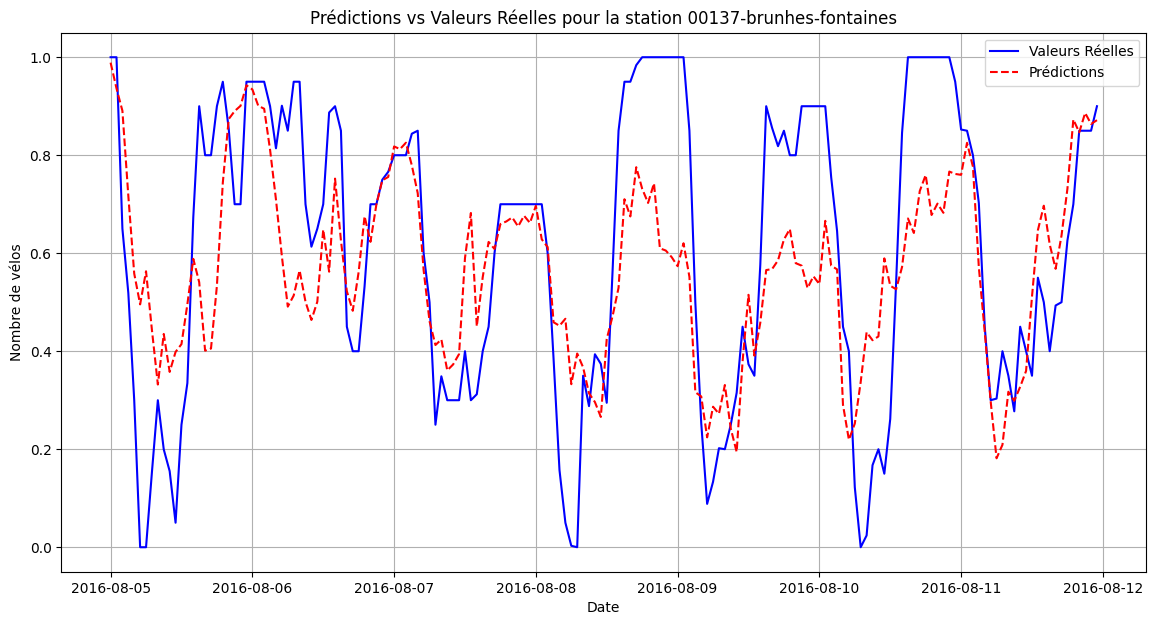

In [47]:
new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]
model = MLPRegressor(hidden_layer_sizes=(180, 50), activation='relu', solver='lbfgs', random_state=0, max_iter=1000)
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()


Régression linéaire multiple

In [50]:
from sklearn.linear_model import LinearRegression

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24 * 7  # Prédiction sur une semaine

station = method.df_dataset.columns[150]

model = LinearRegression()
X_train = method.train_dataset.drop(station, axis=1)
y_train = method.train_dataset[station]
X_test = method.df_dataset.drop(station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')
r_squared = model.score(X_test, y_test)
print(f'R² pour les prédictions sur la station {station}: {r_squared}')


MSE pour les prédictions sur la station 00238-herbettes-butte: 0.131839189092653
R² pour les prédictions sur la station 00238-herbettes-butte: -0.8047882402575737


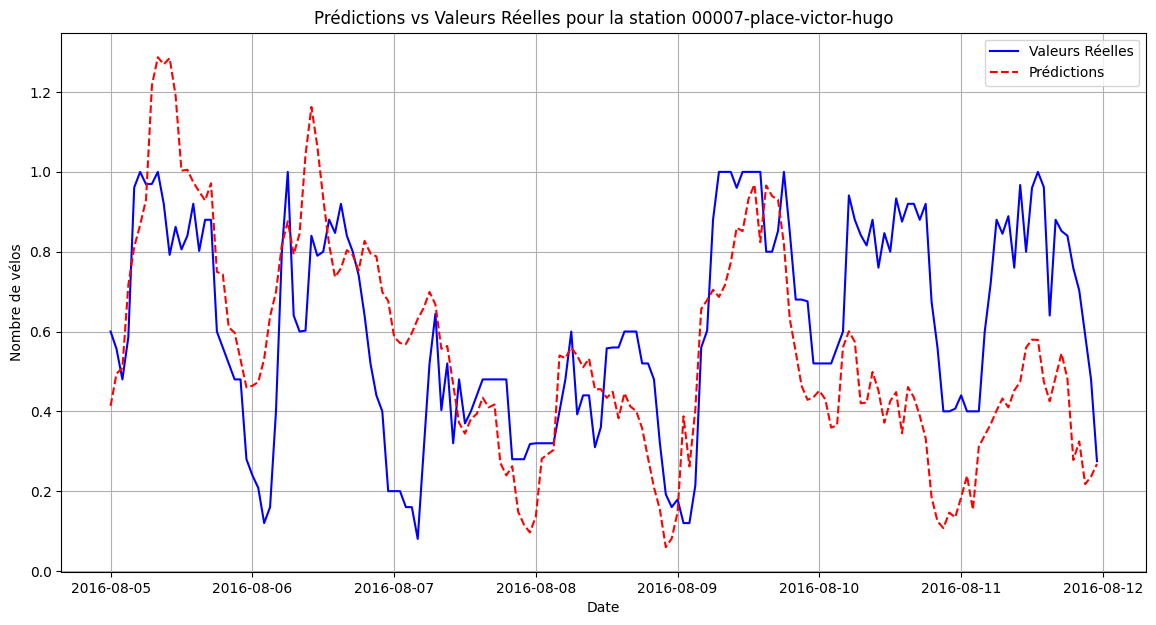

In [53]:
new_station = method.df_dataset.columns[1]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]
model = LinearRegression()
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

Apprentissage profond supervisé

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24 * 7  # Prédiction sur une semaine

model = keras.Sequential([
    keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)
predictions = model.predict(X_test_scaled)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - loss: 0.1970
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0248
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.0129
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0085
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.0062
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0051
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 0.0040
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0037
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0032
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 0.0024
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.0022
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0022
Epoch 13/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0025
Epoch 14/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.0020
Epoch 15/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.0025


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - loss: 0.3886
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0344
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0161
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.0099
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0077
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.0051
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0045
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0036
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.0033
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.0029
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.0023
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0023
Epoch 13/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0020
Epoch 14/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0018  
Epoch 15/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.001

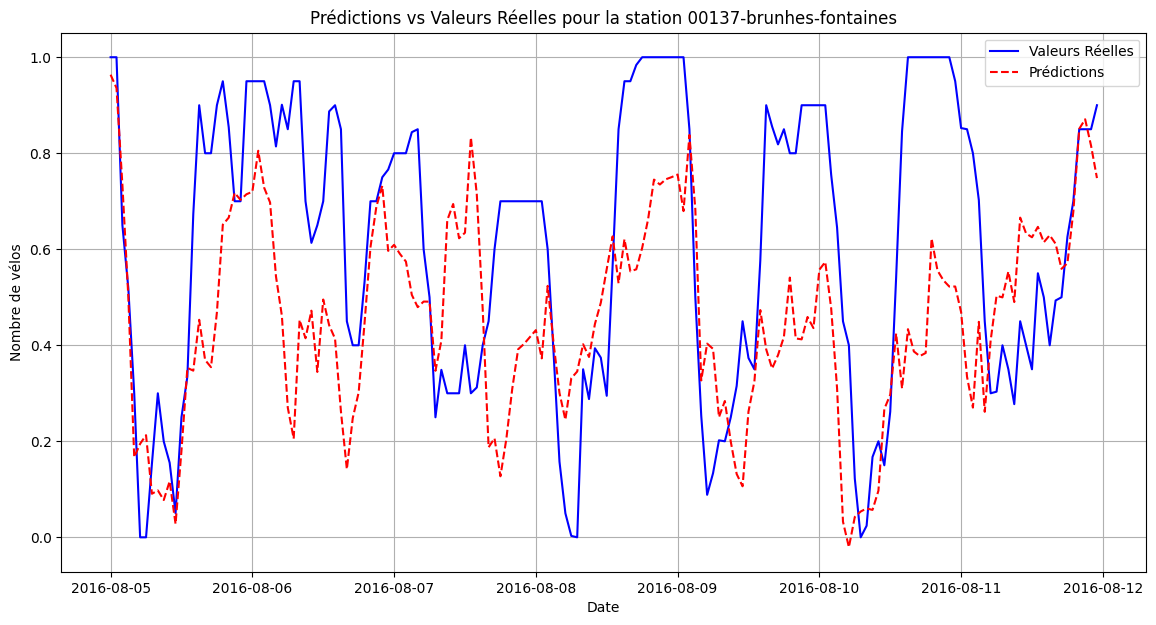

In [ ]:
new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]

model = keras.Sequential([
    keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)
predictions = model.predict(X_test_scaled)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

SARIMA (Seasonal Autoregressive Integrated Moving Average) : Une méthode classique de modélisation des séries temporelles prenant en compte la saisonnalité, les tendances et les composantes autoregressives.

d:\Documents\GitHub\TER\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Documents\GitHub\TER\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Documents\GitHub\TER\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Documents\GitHub\TER\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


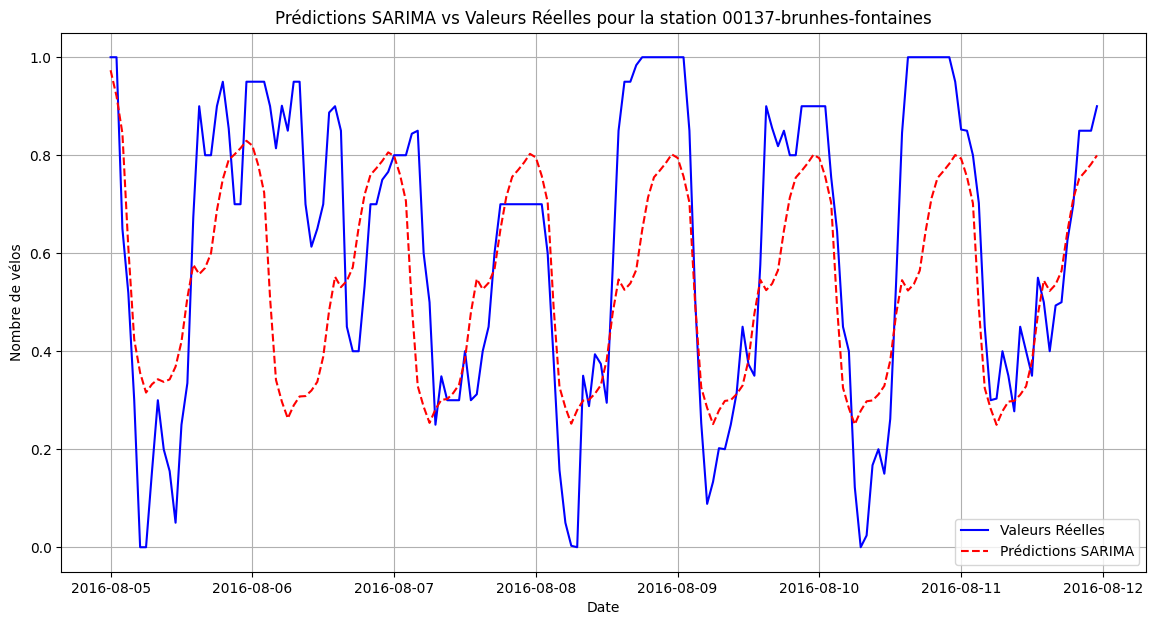

MSE pour les prédictions SARIMA sur la station 00137-brunhes-fontaines: 0.04867450187355185
R² pour les prédictions SARIMA sur la station 00137-brunhes-fontaines: 0.45252391878734866


In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]

train_data = method.df_dataset[:last_train_date]
test_data = method.df_dataset[start_prediction:end_prediction]

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)  # Saisonnalité quotidienne
model = SARIMAX(train_data[new_station], order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
results = model.fit()

predictions = results.get_forecast(steps=len(test_data)).predicted_mean

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(test_data.index, predictions, label='Prédictions SARIMA', color='red', linestyle='--')
plt.title(f'Prédictions SARIMA vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(test_data[new_station], predictions)
print(f'MSE pour les prédictions SARIMA sur la station {new_station}: {mse}')
# Compute R² from sarima predictions
from sklearn.metrics import r2_score

r_squared = r2_score(test_data[new_station], predictions)
print(f'R² pour les prédictions SARIMA sur la station {new_station}: {r_squared}')



Méthodes d'ensemble : gradient boosting

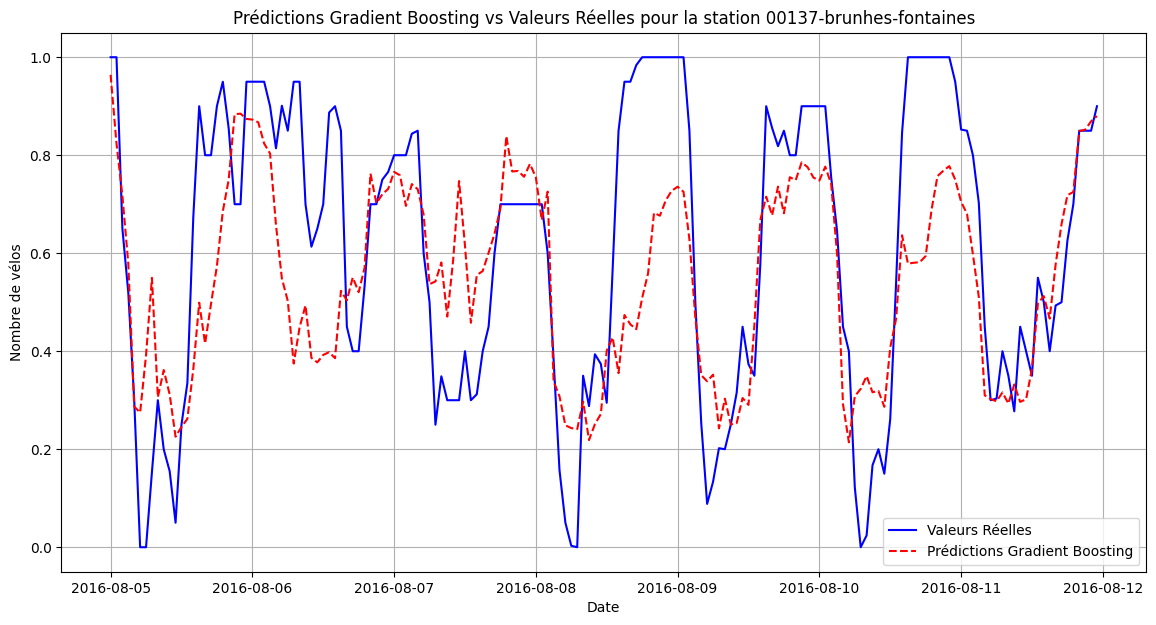

MSE pour les prédictions Gradient Boosting sur la station 00137-brunhes-fontaines: 0.04830096396841307


In [5]:
from sklearn.ensemble import GradientBoostingRegressor

PREDICTION_LENGTH = 24 * 7  # Prédiction sur une semaine

new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]

X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions Gradient Boosting', color='red', linestyle='--')
plt.title(f'Prédictions Gradient Boosting vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions Gradient Boosting sur la station {new_station}: {mse}')


In [ ]:
start_date = real_data.index[0]  # Première date dans l'ensemble de données
end_date = real_data.index[-1]  # Dernière date dans l'ensemble de données

print("Date de début :", start_date)
print("Date de fin :", end_date)


Date de début : 2016-08-05 00:00:00
Date de fin : 2016-08-11 23:00:00


In [ ]:
import datetime

date_9_may = datetime.datetime(2016, 8, 9)
data_9_may = real_data[real_data.index.date == date_9_may.date()]

print(data_9_may)


date
2016-08-09 00:00:00    1.000000
2016-08-09 01:00:00    1.000000
2016-08-09 02:00:00    0.850000
2016-08-09 03:00:00    0.500000
2016-08-09 04:00:00    0.253392
2016-08-09 05:00:00    0.088513
2016-08-09 06:00:00    0.133537
2016-08-09 07:00:00    0.202088
2016-08-09 08:00:00    0.200000
2016-08-09 09:00:00    0.250000
2016-08-09 10:00:00    0.315320
2016-08-09 11:00:00    0.450000
2016-08-09 12:00:00    0.373413
2016-08-09 13:00:00    0.350000
2016-08-09 14:00:00    0.576358
2016-08-09 15:00:00    0.900000
2016-08-09 16:00:00    0.855631
2016-08-09 17:00:00    0.818456
2016-08-09 18:00:00    0.850000
2016-08-09 19:00:00    0.800000
2016-08-09 20:00:00    0.800000
2016-08-09 21:00:00    0.900000
2016-08-09 22:00:00    0.900000
2016-08-09 23:00:00    0.900000
Name: 00137-brunhes-fontaines, dtype: float64


In [ ]:
X_train_until_8_may = X_train.loc[:'2016-08-08']
y_train_until_8_may = y_train.loc[:'2016-08-08']
X_test_9_may = X_test.loc['2016-08-09']
y_test_9_may = y_test.loc['2016-08-09']

model.fit(X_train_until_8_may, y_train_until_8_may)
predictions_9_may = model.predict(X_test_9_may)


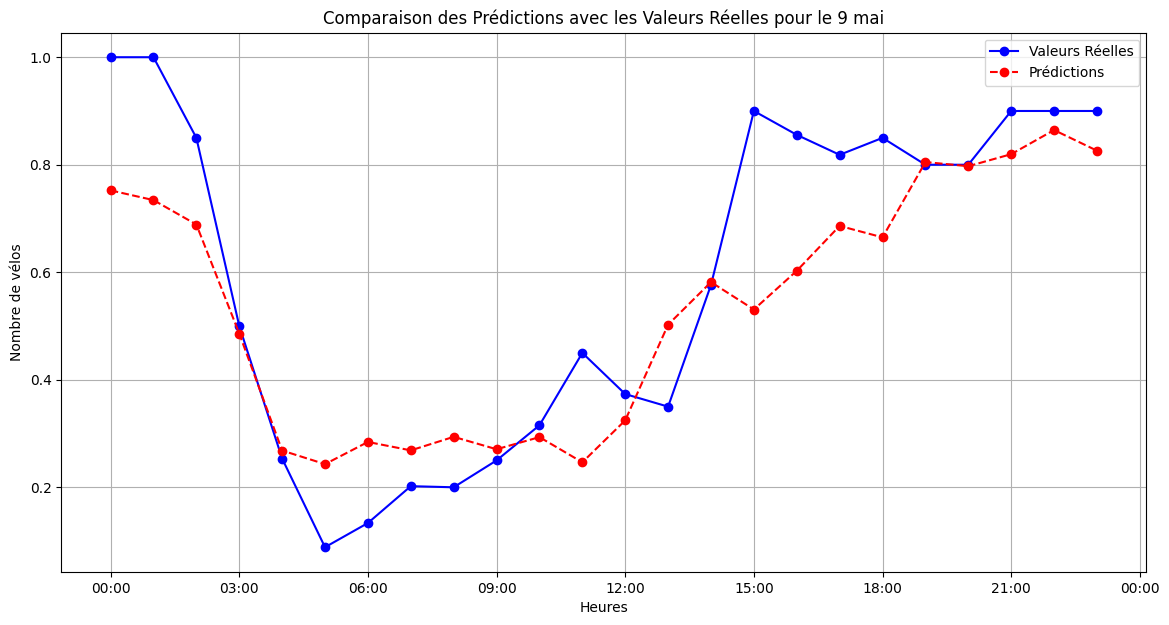

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))
plt.plot(data_9_may.index, data_9_may.values, label='Valeurs Réelles', color='blue', marker='o')
plt.plot(data_9_may.index, predictions_9_may, label='Prédictions', color='red', linestyle='--', marker='o')
plt.title('Comparaison des Prédictions avec les Valeurs Réelles pour le 9 mai')
plt.xlabel('Heures')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True)
plt.show()


C:\Users\theo3\AppData\Local\Temp\ipykernel_20776\1895352500.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pred_index = pd.date_range(start=start_prediction, periods=len(forecast['mean']), freq='H')


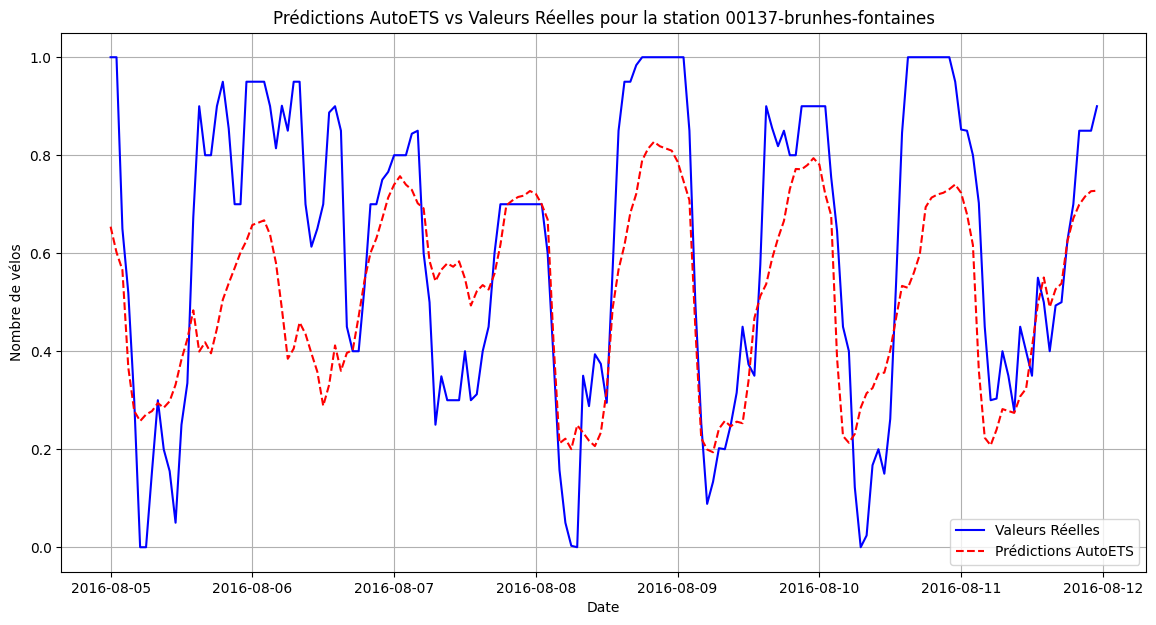

MSE: 0.04887217515620456
R²: 0.45030054946703624


In [95]:
from statsforecast.models import AutoETS
import pandas as pd
import matplotlib.pyplot as plt

new_station = method.df_dataset.columns[78]
last_train_date = method.train_dataset.index[-1]
start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

train_data = method.df_dataset[:last_train_date]
test_data = method.df_dataset[start_prediction:end_prediction]

y_train = train_data[new_station].dropna().values

model = AutoETS(season_length=168, model='AAA', damped=True)
model.fit(y=y_train)

forecast = model.predict(h=len(test_data))

pred_index = pd.date_range(start=start_prediction, periods=len(forecast['mean']), freq='H')
forecast_series = pd.Series(forecast["mean"], index=pred_index)

plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data[new_station], label='Valeurs Réelles', color='blue')
plt.plot(forecast_series.index, forecast_series.values, label='Prédictions AutoETS', color='red', linestyle='--')
plt.title(f'Prédictions AutoETS vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_data[new_station], forecast_series)
r_squared = r2_score(test_data[new_station], forecast_series)

print(f'MSE: {mse}')
print(f'R²: {r_squared}')


05:35:58 - cmdstanpy - INFO - Chain [1] start processing
05:35:59 - cmdstanpy - INFO - Chain [1] done processing
WARNING - (py.warnings._showwarnmsg) - d:\Documents\GitHub\TER\venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(



MSE: 0.06806622756713959, R2 Score: 0.5169994320368931


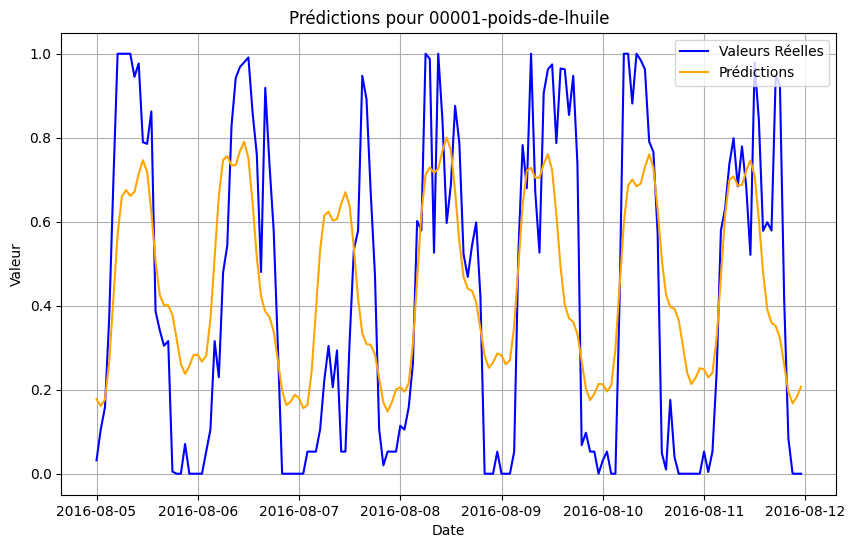

In [78]:
import pandas as pd
from prophet import Prophet

station = method.df_dataset.columns[0]
train_data = method.df_dataset[:last_train_date]
train_data_prophet = train_data.reset_index().rename(columns={'date': 'ds', station: 'y'})

# Modèle Prophet amélioré
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.8  # Plus flexible pour mieux s'adapter aux changements
)
model.add_seasonality(name='daily', period=1, fourier_order=100)  # Ajuster fourier_order pour la saisonnalité journalière
model.add_seasonality(name='weekly', period=7, fourier_order=100)  # Ajuster fourier_order pour la saisonnalité hebdomadaire

# Entraînement du modèle
model.fit(train_data_prophet)

# Préparation des données de prédiction
future = model.make_future_dataframe(periods=24 * 7, freq='H')  # Période d'une semaine en heures
forecast = model.predict(future)

# Comparaison des résultats (si les valeurs réelles sont disponibles pour la période prédite)
test_data = method.df_dataset[start_prediction:end_prediction]
test_data_prophet = test_data.reset_index().rename(columns={'date': 'ds', station: 'y'})

results = pd.merge(forecast[['ds', 'yhat']], test_data_prophet, on='ds')

# Calcul des métriques d'évaluation
mse = ((results['y'] - results['yhat']) ** 2).mean()
r2 = 1 - ((results['y'] - results['yhat']) ** 2).sum() / ((results['y'] - results['y'].mean()) ** 2).sum()

print(f"MSE: {mse}, R2 Score: {r2}")

# Graphiques personnalisés
plt.figure(figsize=(10, 6))
plt.plot(results['ds'], results['y'], label='Valeurs Réelles', color='blue')
plt.plot(results['ds'], results['yhat'], label='Prédictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title(f'Prédictions pour {station}')
plt.legend()
plt.grid(True)
plt.show()


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


WARNING - (py.warnings._showwarnmsg) - d:\Documents\GitHub\TER\venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.967% of the data.
WARNING - (py.warnings._showwarnmsg) - d:\Documents\GitHub\TER\venv\Lib\site-packages\neuralprophet\df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - d:\Documents\GitHub\TER\venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datet

Epoch 80: 100%|██████████| 80/80 [00:00<00:00, 219.12it/s, loss=0.0754, v_num=7, MAE=0.191, RMSE=0.255, Loss=0.0692, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - d:\Documents\GitHub\TER\venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.967% of the data.
WARNING - (py.warnings._showwarnmsg) - d:\Documents\GitHub\TER\venv\Lib\site-packages\neuralprophet\df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - d:\Documents\GitHub\TER\venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datet

Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 137.92it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


MSE: 0.05354026187980998, R2 Score: 0.6200762430776147


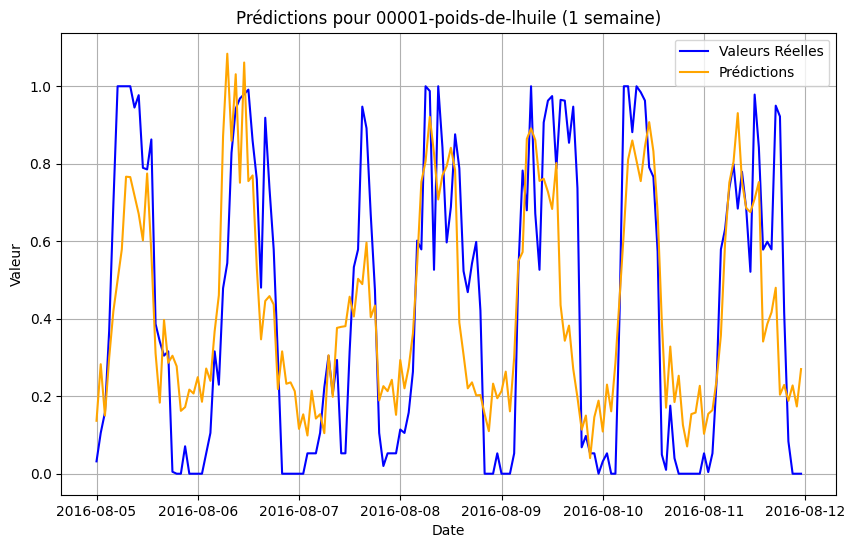

In [72]:
import pandas as pd
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Configuration des périodes d'entraînement et de test
train_data = method.df_dataset[:last_train_date]
test_data = method.df_dataset[last_train_date + pd.DateOffset(hours=1):]

# Limitez les données de test à une semaine
PREDICTION_LENGTH = 24 * 7  # 7 jours en heures
test_data = test_data.iloc[:PREDICTION_LENGTH]

# Nom de la colonne de la station à prédire
station = method.df_dataset.columns[0]

# Préparation des données en sélectionnant uniquement la colonne station
train_data_neural = train_data[[station]].reset_index().rename(columns={'date': 'ds', station: 'y'})
test_data_neural = test_data[[station]].reset_index().rename(columns={'date': 'ds', station: 'y'})

# Entraînement du modèle NeuralProphet
np_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,  # Utilisez la saisonnalité quotidienne intégrée
    n_changepoints=100,  # Nombre de points de changement
    learning_rate=0.5  # Taux d'apprentissage
)
np_model.add_country_holidays(country_name='FR')
np_model.add_seasonality(name='custom_weekly', period=7, fourier_order=100)  # Renommez cette saisonnalité pour ne pas entrer en conflit
np_model.fit(train_data_neural, freq='H')

# Préparation des données de prédiction pour une semaine
future = np_model.make_future_dataframe(train_data_neural, periods=PREDICTION_LENGTH, n_historic_predictions=True)
forecast = np_model.predict(future)

# Comparaison avec les données réelles
forecast_test = forecast.tail(PREDICTION_LENGTH)
y_true = test_data_neural['y'].values
y_pred = forecast_test['yhat1'].values

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"MSE: {mse}, R2 Score: {r2}")

# Graphique des résultats
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_true, label='Valeurs Réelles', color='blue')
plt.plot(test_data.index, y_pred, label='Prédictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title(f'Prédictions pour {station} (1 semaine)')
plt.legend()
plt.grid(True)
plt.show()
